# Importing packages

In [119]:
import numpy as np
import pandas as pd
import scipy
from scipy import special
from sympy import symbols, Eq, nsolve, sqrt
from matplotlib import pyplot as plt

# Model Assumptions

In [2]:
# Distribution parameters
v = 7.5 # Degree of freedom scalar

# Asset parameters
Rf = 1.0 # Gross interest rate
γ_hat = 0.6 # Portfolio risk aversion
σ_M = 0.25 # Volatility of market returns

# Prospect Theory parameters
α = 0.7 # Dimishing sensitivity parameter
δ = 0.65 # Probability weighting parameter
λ = 1.5 # Loss averse parameter
b_hat = 0.6 # Prospect theory term

# Data Inputs

In [3]:
df = pd.read_excel("empirical_input.xls")
inputs = df.iloc[[0, -1]].reset_index(drop = True)
inputs["Capitalisation"] = [0.4, 0.6]

inputs

,Return,StDev,Skew,Overhang,Beta,Capitalisation
0,0.009404,0.368488,2.468040,0.104735,0.842076,0.4
1,-0.002700,0.943178,3.790273,-0.316220,1.126670,0.6


# Moments of distribution
The mean, variance and skewness of the distribution are 
$$\begin{align}
E(\tilde{R_i})=\bar{R_i}&= \mu_i + \frac{v}{v-2}\zeta_i\\
Var(\tilde{R_i}) &= \frac{v}{v-2} S_i + \frac{2v^2}{(v-2)^2(v-4)}\zeta_i^2\\
Skew(\tilde{R_i}) &= \frac{2\zeta_i\sqrt{v(v-4)}}{\sqrt{S_i}(2v\zeta_i^2/S_i+(v-2)(v-4))^{\frac{3}{2}}}\bigg(3(v-2)+\frac{8v\zeta_i^2}{S_i(v-6)}\bigg)
\end{align}$$

In [4]:
def E(μ, ζ):
    """Mean of distribution"""
    return μ + (v/(v-2))*ζ

def var(ζ, sqrt_S):
    """Variance of distribution"""
    return (v/(v-2))*(sqrt_S**2) + (2 * (ζ**2) * (v**2)) / (v-4) / ((v-2)**2)

def skew(ζ, sqrt_S):
    """Skewness of distribution"""
    return (3*(v-2)+((8*v*(ζ**2))/(v-6)/((sqrt_S)**2))) * (2*ζ*math.sqrt(v*(v-4))) / (sqrt_S) / ((2*v*(ζ**2)/(sqrt_S**2)) + (v-2)*(v-4))**(1.5)

# Parameter solving

In [5]:
def parameter_solver(StDev, Skew):
    """Finds ζ and sqrt_S so that variance and skewness match"""
    ζ1, sqrt_S1 = symbols('ζ1, sqrt_S1') # The variables
    eq1 = Eq(var(ζ1, sqrt_S1), StDev**2) 
    eq2 = Eq(skew(ζ1, sqrt_S1), Skew) 
    result = nsolve([eq1, eq2], [ζ1, sqrt_S1], [1, 1]) # Solve simultaneous equation
    return result

# Running parameter solver for input table

In [6]:
# Create empty arrays
result = np.empty([len(inputs),2])

# Populate arrays with results of parameter_solver
for i in range(len(inputs)):
    result[i:,] = list(parameter_solver(inputs["StDev"][i], inputs["Skew"][i]))

# Create dataframe
column_values = ['ζ', 'sqrt_S']
parameters = pd.DataFrame(data = result, columns = column_values)

parameters

,ζ,sqrt_S
0,0.217965,0.250109
1,0.692359,0.528048


# Probability and Cumulative Distribution Functions

### Probability Density Function

Each distribution has a one-dimensional generalised hyperbolic skewed t distribution, with density function

$$
p(R_i) = \frac{2^{1-\frac{v+1}{2}}}{\Gamma(\frac{v}{2})(\pi v S_i)^{\frac{1}{2}}}
\cdot \frac{K_{\frac{v+1}{2}}\bigg(\sqrt{(v+(R_i-\mu_i)^2/S_i)\zeta_i^2/S_i)}\bigg)\text{exp}((R_i-\mu_i)\zeta_i/S_i)}{\bigg(\sqrt{(v+(R_i-\mu_i)^2/S_i)\zeta_i^2/S_i)}\bigg)^{-\frac{v+1}{2}}(1+(R_i-\mu_i)^2v^{-1}/S_i)^{\frac{v+1}{2}}}
$$
for $\zeta\neq 0$, and 
$$
p(R_i) = \frac{\Gamma(\frac{v+1}{2})}{\Gamma(\frac{v}{2})(\pi vS_i)^{\frac{1}{2}}}\cdot
(1+(R_i-\mu_i)^2v^{-1}/S_i)^{\frac{v+1}{2}}
$$
for $\zeta_i=0$.

### Defining functions to simplify pdf

In [107]:
def sqrt_function(R, μ, ζ, sqrt_S):
    """Creating the sqrt part above"""
    result = np.float32((v + (R - μ)**2 / (sqrt_S**2)) * (ζ**2) / (sqrt_S**2))
    return np.sqrt(result)

def vplus1_function(R, μ, ζ, sqrt_S):
    """Creating the (v+1)/2 function"""
    result = 1 + (((R - μ)**2) / (sqrt_S**2) / v)
    return float(result**((v+1)/2))

def gamma_function(sqrt_S):
    """Creating denominator"""
    result = np.pi * v * (sqrt_S**2)
    return float(scipy.special.gamma(v/2) * result**0.5)

def exp_function(R, μ, ζ, sqrt_S):
    """Creating exp part"""
    result = (R - μ) * ζ / (sqrt_S**2)
    return float(np.exp(result))

def bessel_function(R, μ, ζ, sqrt_S):
    '''Creating bessel function'''
    result = scipy.special.kv((v+1)/2, sqrt_function(R, μ, ζ, sqrt_S))
    return float(result)

### PDF at each point R

In [8]:
def pdf(R, μ, ζ, sqrt_S):
    """Point by point pdf. This creates the above function taking in a specific R as an argument"""
    if ζ == 0:
        density = scipy.special.gamma((v+1)/2) * vplus1_function(R, μ, ζ, sqrt_S) / gamma_function(sqrt_S)
    else: 
        density = (2**(1-((v+1)/2))) * bessel_function(R, μ, ζ, sqrt_S) * exp_function(R, μ, ζ, sqrt_S) / gamma_function(sqrt_S) / (sqrt_function(R, μ, sqrt_S, ζ)**(-(v+1)/2)) / vplus1_function(R, μ, ζ, sqrt_S)
    return density

### Range of returns considered

In [9]:
delta_r = 1/300 # Width of increment between R's
lower_limit = -50 # Lower limit of R
upper_limit = 50 # Upper limit of R

num = (upper_limit - lower_limit) / delta_r + 1 # Number of spaces in vector
ret_vec = np.linspace(lower_limit, upper_limit, int(num)) # Discretised return vector

M = len(ret_vec) # Length of vector

### Building PDF and CDF

In [10]:
def pdf_total(μ, ζ, sqrt_S):
    """Creating the distribution for an asset with parameters μ, ζ, sqrt_S"""
    outputs = [pdf(R, μ, ζ, sqrt_S) for R in ret_vec]
    return outputs

def cdf_total(μ, ζ, sqrt_S):
    """Creates the CDF for an asset with parameters μ, ζ, sqrt_S"""
    outputs = np.cumsum(pdf_total(μ, ζ, sqrt_S)) * delta_r
    return outputs.tolist()

### Example of PDF and CDF

Here we set $\mu=0$, sqrt_S$=0.2$ and $\zeta=0.2$

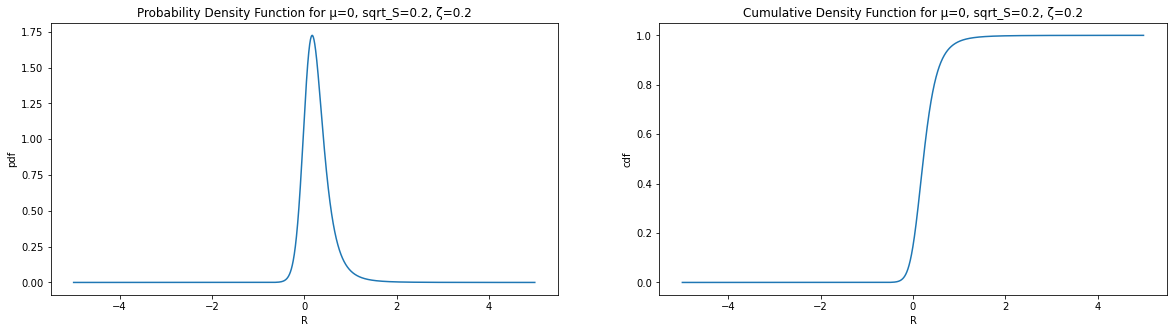

In [11]:
# Index in ret_vec when the value is -5.
a = int(min(i for i in list(range(M)) if i > (upper_limit - 5) / delta_r)) 

plt.subplots(2, 2, figsize=(20,5))

plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.plot(ret_vec[a:(M-a)], pdf_total(0, 0.2, 0.2)[a:(M-a)]) # Only graph between (-5,5)
plt.xlabel('R')
plt.ylabel('pdf')
plt.title('Probability Density Function for μ=0, sqrt_S=0.2, ζ=0.2')

plt.subplot(1, 2, 2) # row 1, col 2 index 2
plt.plot(ret_vec[a:(M-a)], cdf_total(0, 0.2, 0.2)[a:(M-a)]) # Only graph between (-5,5)
plt.xlabel('R')
plt.ylabel('cdf')
plt.title('Cumulative Density Function for μ=0, sqrt_S=0.2, ζ=0.2')

plt.show()

# Prospect Theory

The value function is $$v(x)=\begin{cases}x^{\alpha}, & x\geq 0\\-\lambda(-x)^{\alpha},&x<0\end{cases}$$

The probability weighting function is 
$$
w(P)=\frac{P^{\delta}}{(P^{\delta}+(1-P)^{\delta})^{1/\delta}}
$$

The quantity $V(\tilde{G_i})$ is the cumulative prospect theory value of the gain or loss $\tilde{G_i}$. For $\Theta_i>0$, we have 
\begin{align*}
V(\tilde{G_i})&=-\lambda \int\limits_{-\infty}^{R_f-\theta_{i,-1}g_i/\theta_i} (\theta_i(R_f-R_i)-\theta_{i,-1}g_i)^{\alpha} dw(P(R_i))\\&-\int\limits_{R_f-\theta_{i,-1}g_i/\theta_i}^{\infty} (\theta_i(R_i-R_f)+\theta_{i,-1}g_i)^{\alpha} dw(1-P(R_i))
\end{align*}
______________

#### Gain/Loss Term:
The integrated gain/loss for asset $i$ for the cumulative prospect theory term in scaled down objective function
$$
\theta_i(\tilde{R_i}-R_f)+\theta_{i,-1}g_i.
$$

#### Loss Derivative: 
We have $$dw(P(R_i))=\frac{dw(P(R_i))}{dP(R_i)}\frac{dP(R_i)}{dR_i}dR_i$$
with 
$$
\frac{dw(P(R_i))}{dP(R_i)}=\frac{\delta P^{\delta -1}(P^{\delta}+(1-P)^{\delta})-P^{\delta}(P^{\delta-1}-(1-P)^{\delta-1})}{(P^{\delta}+(1-P)^{\delta})^{1+\frac{1}{\delta}}}
$$
using $P$ as short-hand for $P(R_i)$
___________

#### Gain Derivative:
We have $$dw(1-P(R_i))=\frac{dw(1-P(R_i))}{dP(R_i)}\frac{dP(R_i)}{dR_i}dR_i$$
with 
$$
\frac{dw(1-P(R_i))}{dP(R_i)}=\frac{\delta (1-P)^{\delta -1}(P^{\delta}+(1-P)^{\delta})-(1-P)^{\delta}((1-P)^{\delta-1}-P^{\delta-1})}{(P^{\delta}+(1-P)^{\delta})^{1+\frac{1}{\delta}}}
$$
using $P$ as short-hand for $P(R_i)$
___________

### Define these functions

In [12]:
def gain(R, cgo, θ_M, θ):
    """Gain/loss of asset i given outcome of random variable Ri and chosen optimal θ"""
    return float(θ * (R - Rf) + θ_M * cgo)

def derivative_loss(P):
    """dw(P(R))/d(P(R))"""
    numerator = (δ * P**(δ-1)) * (P**δ + (1-P)**δ) - P**δ * (P**(δ-1) - (1-P)**(δ-1))
    denominator = (P**δ + (1-P)**δ) ** (1+1/δ)
    derivative = numerator / denominator
    return float(derivative)

def derivative_gain(P):
    """dw(1-P(R))/d(P(R))"""
    numerator = (δ * (1-P)**(δ-1)) * (P**δ + (1-P)**δ) - (1-P)**δ * ((1-P)**(δ-1) - P**(δ-1))
    denominator = (P**δ + (1-P)**δ) ** (1 + 1/δ)
    derivative = numerator / denominator
    return float(derivative)

###  Cumulative Prospect Theory term

In [101]:
μ = 0.5
ζ = 0.6
sqrt_S = 0.5
cgo = 0.1
θ_M = 0.26
θ = 0.26
β = 0.9
σ_M = 0.25

In [52]:
def CPT(μ, ζ, sqrt_S, cgo, θ_M, θ):
    """Calculates CPT term"""
    
    # Finds index in ret_vec that corresponds to the R which gives a gain/loss of zero
    cutoff = Rf - cgo * θ_M / θ
    m = min(R for R in ret_vec if R >= cutoff) # minimum value in ret_vec >= cutoff
    idx = list(ret_vec).index(m) # Index of m used to find 
    
    # Creates the vector of this assets pdf and cdf. It will be same size as ret_vec
    pdf = pdf_total(μ, ζ, sqrt_S)
    cdf = cdf_total(μ, ζ, sqrt_S)
   

    # This section calculates the gain portion of CPT term V(G)

    gains_skew_dist_pdf = pdf[idx:] # Portion of pdf vector which corresponds to gains
    gains_skew_dist_cdf = cdf[idx:] # Portion of cdf vector which corresponds to gains
    gains_ret_vec_sub = ret_vec[idx:] # Portion of returns vector which corresponds to gains
    
    gains_vector = [((abs(gain(R, θ, θ_M, cgo))**α * p * derivative_gain(P))) 
                    for R, p, P in zip(gains_ret_vec_sub, gains_skew_dist_pdf, gains_skew_dist_cdf)]
    gains = sum(gains_vector) * delta_r
    
    
    # This section calculates the loss portion of CPT term V(G)
    
    losses_skew_dist_pdf = pdf[:idx-1]
    losses_skew_dist_cdf = cdf[:idx-1]
    losses_ret_vec_sub = ret_vec[:idx-1]
    
    losses_vector = [((-λ*(abs(gain(R, θ, θ_M, cgo)))**α) * p * derivative_loss(P)) 
                     for R, p, P in zip(losses_ret_vec_sub, losses_skew_dist_pdf, losses_skew_dist_cdf)]
    losses = sum(losses_vector) * delta_r

    # Return the gains and losses part summed
    
    return gains + losses

In [53]:
theta_space = np.linspace(0.01, 0.99, 100)

y = [CPT(μ, ζ, sqrt_S, cgo, θ_M, i) for i in theta_space]

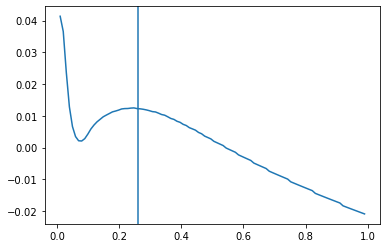

In [54]:
plt.plot(theta_space,y)
plt.axvline(x=θ_M)

# Initial guess of mu assuming homogeneity

In [55]:
def CPT_theta_epsilon(μ, ζ, sqrt_S, cgo, θ_M, ϵ = 0):
    """Returns the CPT term when an investor chooses θ to be equal to θ_M plus ϵ.
    ....Note that when ϵ=0, the investor has homogeneous holdings.
    ....This function will be used to calculate partial derivative of objective function
    with respect to θ"""
    
    return CPT(μ, ζ, sqrt_S, cgo, θ_M, θ = (θ_M + ϵ))

The partial derivative of the objective function with respect to $\theta_i$ is 
$$
\begin{align*}
&\mu_i+\frac{v\zeta_i}{v-2}-R_f\\
& - \hat{\gamma}(\theta_i\sigma_i^2 + \beta_i\sigma_M^2 - \theta_{M,i}\sigma_i^2)\\
& +\hat{b} (V(G)')
\end{align*}
$$

In [110]:
def objective_derivative(μ, ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200):
    """Calculates the above"""
    
    # Calculate the variance term in derivative (second line without γ_hat). Note that θ = θ_M
    variance_derivative_term = lambda ζ, sqrt_S, β, θ_M : θ_M * var(ζ, sqrt_S) + β * (σ_M**2) - θ_M * var(ζ, sqrt_S)
    
    # Now calculate result
    result = E(μ, ζ) - Rf - γ_hat * variance_derivative_term(ζ, sqrt_S, β, θ_M) \
            + b_hat * (CPT_theta_epsilon(μ, ζ, sqrt_S, cgo, θ_M, ϵ) - CPT_theta_epsilon(μ, ζ, sqrt_S, cgo, θ_M, ϵ = 0)) / ϵ
    
    return float(result)

In [111]:
# An example for the parameters above

objective_derivative(μ, ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200)

0.2844318181818181

   Set partial derivative of the objective function with respect to $\theta_i$ to zero and solve for $\mu$

In [112]:
def initial_guess(ζ, sqrt_S, cgo, β, θ_M):
    '''Makes an initial guess for mu'''
    guess = Rf + γ_hat * (θ_M * var(ζ, sqrt_S) + β * σ_M**2) - v * ζ / (v-2)
    return guess

In [113]:
def mu_homogeneous_guess(ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200):
    """Finds mu that maximises the objective function given homogeneous holdings"""
    μ1, y = symbols('μ1, y')
    y = objective_derivative(μ1, ζ = 0.2, sqrt_S = 0.2, cgo = 0, β = 1, θ_M = 0.1, ϵ = 1/200)
    sol = solve(y)
    return sol

In [114]:
def mu_homogeneous_guess1(ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200):
    """Finds ζ and sqrt_S so that variance and skewness match"""
    
    #Makes an initial guess for mu
    guess = Rf + γ_hat * (θ_M * var(ζ, sqrt_S) + β * σ_M**2) - v * ζ / (v-2)
    
    μ1 = symbols('μ1') # The variable
    eq = Eq(objective_derivative(μ1, ζ = 0.2, sqrt_S = 0.2, cgo = 0, β = 1, θ_M = 0.1, ϵ = 1/200), 0) 
    result = nsolve([eq], guess) # Solve equation
    return result

In [120]:
mu_homogeneous_guess1(ζ, sqrt_S, cgo, β, θ_M, ϵ = 1/200)

TypeError: can't convert expression to float